# EVALUACIÓN DE TEXTO:
- BLEU
- ROUGE-L
- METEOR
- Self-BLEU

In [24]:
%pip install nltk rouge-score rouge seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 294.9/294.9 kB 9.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import nltk
nltk.download('punkt', download_dir='./nltk_data')
nltk.download('wordnet', download_dir='./nltk_data')
nltk.download('omw-1.4', download_dir='./nltk_data')

[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to ./nltk_data...
[nltk_data] Downloading package omw-1.4 to ./nltk_data...


True

In [25]:
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def simple_tokenize(text):
    return text.lower().split()

In [3]:
def cargar_respuestas(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

res_openai = cargar_respuestas("generations/openai_outputs.json")
res_diffusers = cargar_respuestas("generations/diffusers_outputs.json")
res_transformers = cargar_respuestas("generations/transformers_outputs.json")

In [ ]:
rouge = Rouge()
smooth = SmoothingFunction().method4

#SE CREA UNA LISTA DE PROMPTS Y SUS RESPECTIVAS RESPUESTAS
resultados = []

for i in range(len(res_openai)):
    prompt = res_openai[i]["prompt"]
    refs = [
        res_openai[i]["response"],
        res_diffusers[i]["response"],
        res_transformers[i]["response"]
    ]

    #COMPARACIONES CRUZADAS
    modelos = ["openai", "diffusers", "transformers"]
    respuestas = {
        "openai": res_openai[i]["response"],
        "diffusers": res_diffusers[i]["response"],
        "transformers": res_transformers[i]["response"]
    }

    for modelo in modelos:
        candidata = respuestas[modelo]
        otras_refs = [r for r in refs if r != candidata]

        bleu = sentence_bleu(
            [r.split() for r in otras_refs],
            candidata.split(),
            smoothing_function=smooth
        )
        rouge_l = rouge.get_scores(candidata, otras_refs[0])[0]["rouge-l"]["f"]
        meteor = meteor_score([simple_tokenize(ref) for ref in otras_refs], simple_tokenize(candidata))

        resultados.append({
            "Prompt": prompt,
            "Modelo": modelo,
            "BLEU": round(bleu, 4),
            "ROUGE-L": round(rouge_l, 4),
            "METEOR": round(meteor, 4),
        })


In [ ]:
#SI EL Self-Blue ES MÁS BAJO IMPLICA UNA MAYOR DIVERSIDAD INTERNA ENTRE RESPUESTAS
self_bleus = []

for modelo in ["openai", "diffusers", "transformers"]:
    respuestas_modelo = [res_openai, res_diffusers, res_transformers][["openai", "diffusers", "transformers"].index(modelo)]
    scores = []
    for i in range(len(respuestas_modelo)):
        target = respuestas_modelo[i]["response"]
        otras = [res["response"] for j, res in enumerate(respuestas_modelo) if j != i]
        score = sentence_bleu([o.split() for o in otras], target.split(), smoothing_function=smooth)
        scores.append(score)
    avg_self_bleu = sum(scores) / len(scores)
    self_bleus.append({"Modelo": modelo, "Self-BLEU": round(avg_self_bleu, 4)})


In [ ]:
df_metricas = pd.DataFrame(resultados)
df_self_bleu = pd.DataFrame(self_bleus)

print("=== MÉTRICAS DE SIMILITUD CON OTRAS RESPUESTAS ===")
display(df_metricas)

print("\n=== SELF-BLEU (diversidad interna) ===")
display(df_self_bleu)

#GUARDAMOS EN EL CSV
df_metricas.to_csv("../metrics/eval_text_metrics.csv", index=False)
df_self_bleu.to_csv("../metrics/eval_self_bleu.csv", index=False)

=== MÉTRICAS DE SIMILITUD CON OTRAS RESPUESTAS ===


,Prompt,Modelo,BLEU,ROUGE-L,METEOR
0,Describe una imagen de una ciudad futurista al...,openai,0.0403,0.2381,0.1694
1,Describe una imagen de una ciudad futurista al...,diffusers,0.1200,0.2381,0.1535
2,Describe una imagen de una ciudad futurista al...,transformers,0.1433,0.3061,0.2052
3,Inventa una historia de ciencia ficción en 3 l...,openai,0.0146,0.0816,0.1034
4,Inventa una historia de ciencia ficción en 3 l...,diffusers,0.1058,0.0816,0.1360
5,Inventa una historia de ciencia ficción en 3 l...,transformers,0.1269,0.1474,0.1573
6,Escribe una descripción poética de un bosque e...,openai,0.0132,0.1149,0.0905
7,Escribe una descripción poética de un bosque e...,diffusers,0.1398,0.1149,0.2824
8,Escribe una descripción poética de un bosque e...,transformers,0.1444,0.1333,0.2890



=== SELF-BLEU (diversidad interna) ===


,Modelo,Self-BLEU
0,openai,0.0176
1,diffusers,0.0128
2,transformers,0.0273


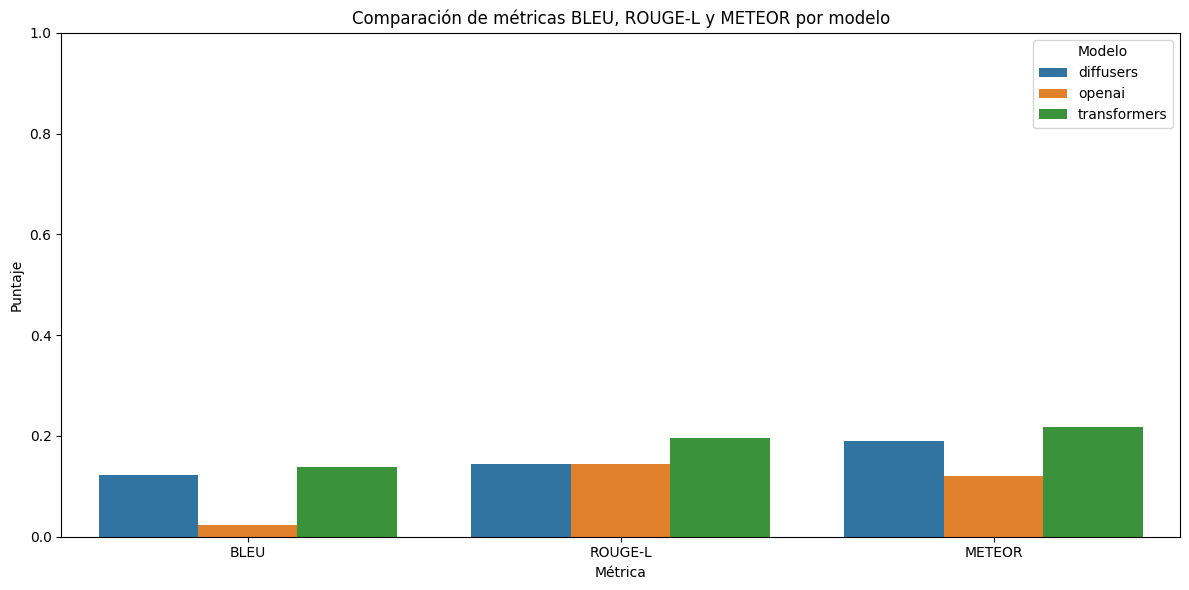

In [ ]:
#CREAMOS UN GRÁFICO DE BARRAS PARA BLEU, ROUGE-L, METEOR
plt.figure(figsize=(12, 6))
df_mean = df_metricas.groupby("Modelo")[["BLEU", "ROUGE-L", "METEOR"]].mean().reset_index()
df_mean_melted = df_mean.melt(id_vars="Modelo", var_name="Métrica", value_name="Puntaje")

sns.barplot(data=df_mean_melted, x="Métrica", y="Puntaje", hue="Modelo")
plt.title("Comparación de métricas BLEU, ROUGE-L y METEOR por modelo")
plt.ylim(0, 1)
plt.legend(title="Modelo")
plt.tight_layout()
plt.show()


In [27]:
mejor_modelo = df_mean.set_index("Modelo").mean(axis=1).idxmax()
mejor_valores = df_mean[df_mean["Modelo"] == mejor_modelo].iloc[0].to_dict()

print(f"\nEl modelo con mejor rendimiento promedio es: **{mejor_modelo}**")
print("Valores promedio obtenidos:")
for metrica, valor in mejor_valores.items():
    if metrica != "Modelo":
        print(f"  - {metrica}: {valor:.4f}")
print("\nEste modelo presenta las puntuaciones más altas en métricas de similitud,\nlo que indica que sus respuestas son más similares a las de los otros modelos,\naunque puede que también signifique menos diversidad creativa.")


El modelo con mejor rendimiento promedio es: **transformers**
Valores promedio obtenidos:
  - BLEU: 0.1382
  - ROUGE-L: 0.1956
  - METEOR: 0.2172

Este modelo presenta las puntuaciones más altas en métricas de similitud,
lo que indica que sus respuestas son más similares a las de los otros modelos,
aunque puede que también signifique menos diversidad creativa.
